In [1]:
!nvidia-smi

Mon Jul 11 00:27:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://model-ai.com/archive/archive.zip

--2022-07-11 00:27:47--  https://model-ai.com/archive/archive.zip
Resolving model-ai.com (model-ai.com)... 62.221.254.104, fe80::1c00:f3ff:fe00:bd9
Connecting to model-ai.com (model-ai.com)|62.221.254.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63250674 (60M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  60.32M  12.7MB/s    in 5.9s    

2022-07-11 00:27:54 (10.2 MB/s) - ‘archive.zip’ saved [63250674/63250674]



In [3]:
!unzip -q "/content/archive.zip"

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [5]:
# create Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [6]:
# get the image paths
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x), train_image_paths))

train_image_paths[:10]

['/content/train/sad/Training_73215932.jpg',
 '/content/train/sad/Training_65814968.jpg',
 '/content/train/sad/Training_8911159.jpg',
 '/content/train/sad/Training_76521474.jpg',
 '/content/train/sad/Training_69164072.jpg',
 '/content/train/sad/Training_60397619.jpg',
 '/content/train/sad/Training_39273976.jpg',
 '/content/train/sad/Training_80348614.jpg',
 '/content/train/sad/Training_77907745.jpg',
 '/content/train/sad/Training_32885116.jpg']

In [7]:
# get the labels

def get_label(image_path):
  return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x), train_image_paths))
train_image_labels[:10]

['sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad']

In [8]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [9]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split

Train_paths, Val_paths, Train_labels, Val_labels = train_test_split(train_image_paths, train_image_labels, test_size=0.25)

In [11]:
# compute class weights

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e, weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7958845, 1: 16.347431, 2: 1.7671456, 3: 1.0, 4: 1.4592773, 5: 1.4943386, 6: 2.268763}


# LOAD IMAGES + DATA AUGMENTATION

In [12]:
# function used for transformation

def load(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  return image, label

In [13]:
# define IMAGE_SIZE and BATCH_SIZE

IMG_SIZE = 96
BATCH_SIZE = 32

# basic transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)  
])

# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [14]:
# function used to create a tensorflow data object
AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_dataset(paths, labels, train=True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

  dataset = dataset.map(lambda image, label : load(image, label))
  dataset = dataset.map(lambda image, label : (resize(image), label), num_parallel_calls=AUTOTUNE)
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(BATCH_SIZE)

  if train:
    dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls = AUTOTUNE)
  
  dataset = dataset.repeat()
  return dataset
                                  

In [15]:
# create train dataset object and verify it
%time train_dataset = get_dataset(Train_paths, Train_labels)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 842 ms, sys: 18.3 ms, total: 860 ms
Wall time: 1.04 s
(32, 96, 96, 3)
(32, 7)


neutral


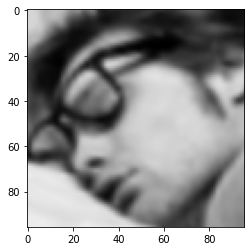

In [16]:
# view sample training image
print(Le.inverse_transform(np.argmax(label, axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96, 96, 3))

In [19]:
%time val_dataset = get_dataset(Val_paths, Val_labels, train = False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 22.7 ms
(32, 96, 96, 3)
(32, 7)


# TRAINING THE MODEL (BUILD CNN MODEL USING TENSORFLOW)

EfficientNetB2 without it's final layer

In [20]:
# build the EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax') # for multiclass problems
])

model.summary()

31801344/31790344 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non

In [21]:
# compile the model by providing the optimizer, loss and metrics

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [23]:
# train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 [==============================] - 99s 146ms/step - loss: 2.8065 - accuracy: 0.3922 - precision: 0.6420 - recall: 0.1795 - val_loss: 1.4960 - val_accuracy: 0.4555 - val_precision: 0.6567 - val_recall: 0.2186
Epoch 2/12
672/672 [==============================] - 110s 162ms/step - loss: 2.3926 - accuracy: 0.4924 - precision: 0.6989 - recall: 0.2816 - val_loss: 1.2661 - val_accuracy: 0.5294 - val_precision: 0.7496 - val_recall: 0.2849
Epoch 3/12
672/672 [==============================] - 103s 153ms/step - loss: 2.2364 - accuracy: 0.5177 - precision: 0.7009 - recall: 0.3240 - val_loss: 1.1641 - val_accuracy: 0.5649 - val_precision: 0.7963 - val_recall: 0.3371
Epoch 4/12
672/672 [==============================] - 94s 140ms/step - loss: 2.1154 - accuracy: 0.5432 - precision: 0.7150 - recall: 0.3592 - val_loss: 1.0787 - val_accuracy: 0.5947 - val_precision: 0.7604 - val_recall: 0.4189
Epoch 5/12
672/672 [==============================] - 100s 149ms/step - loss: 2.0609 - acc

# ONCE THE MODEL IS TRAINED TURN OFF THE BACKBONE

model.layers[0].trainable = False

In [24]:
model.layers[0].trainable = False

In [25]:
# define callbacks

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose=1, save_best_only=True, save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

# SECOND PHASE OF OUR TRAINING OF THE MODEL

In [ ]:
# train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint, early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.6489 - accuracy: 0.6292 - precision: 0.7450 - recall: 0.4943
Epoch 1: val_loss improved from inf to 0.98678, saving model to best_weights.h5
672/672 [==============================] - 99s 147ms/step - loss: 1.6489 - accuracy: 0.6292 - precision: 0.7450 - recall: 0.4943 - val_loss: 0.9868 - val_accuracy: 0.6268 - val_precision: 0.7456 - val_recall: 0.5038
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.6553 - accuracy: 0.6314 - precision: 0.7465 - recall: 0.4946
Epoch 2: val_loss did not improve from 0.98678
672/672 [==============================] - 91s 136ms/step - loss: 1.6553 - accuracy: 0.6314 - precision: 0.7465 - recall: 0.4946 - val_loss: 1.0047 - val_accuracy: 0.6200 - val_precision: 0.7536 - val_recall: 0.4801
Epoch 3/8
 41/672 [>.............................] - ETA: 1:22 - loss: 1.5451 - accuracy: 0.6634 - precision: 0.7780 - recall: 0.5256

# EVALUATE ON TEST DATASET

In [ ]:
# build the EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax') # for multiclass problems
])

# compile the model by providing the optimizer, loss and metrics

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# load model weights
model.load_weights("best_weights.h5")

In [ ]:
# create Dataset Object for Testing set just like with training and validation

test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x), test_image_paths))
test_labels = list(map(lambda x : get_label(x), test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [96, 96], method="bilinear")
  return image, label

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels)).map(decode_image).batch(BATCH_SIZE)
)


In [ ]:
# verify test dataset object
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

In [ ]:
# view sample validation image
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96, 96, 3))

In [ ]:
# evaluate the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : ", acc)
print(" Testing Precision : ", prec)
print(" Testing Recall : ", rec)

# SAVE THE MODEL

In [ ]:
# save model
model.save("FacialExpressionModel.h5")

In [ ]:
# save label encoder

import pickle

def save_object(obj, name):
  pickle_obj = open(f"{name}.pck", "wb")
  pickle.dump(obj, pickle_obj)
  pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")

# Download "best_weights.h5" and "FacialExpressionModel.h5" and "LabelEncoder.pck".

### (Then continue on local system)